In [1]:
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
from pandas import get_dummies
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import numpy
import sys
import csv
import time
import os
import gc
import datetime

In [7]:
with open('../input/class-descriptions.csv', 'r', encoding='utf-8-sig') as f:
    table = csv.reader(f)
    label_name_dict = {key : name for (key,name) in table}

### Let's first take a look at the label box data

In [9]:
train_box_df = pd.read_csv('../input/train/train-annotations-bbox.csv')

In [10]:
train_box_df.head(10)

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside
0,000002b66c9c498e,xclick,/m/01g317,1,0.012500,0.195312,0.148438,0.587500,0,1,0,0,0
1,000002b66c9c498e,xclick,/m/01g317,1,0.025000,0.276563,0.714063,0.948438,0,1,0,0,0
2,000002b66c9c498e,xclick,/m/01g317,1,0.151562,0.310937,0.198437,0.590625,1,0,0,0,0
3,000002b66c9c498e,xclick,/m/01g317,1,0.256250,0.429688,0.651563,0.925000,1,0,0,0,0
4,000002b66c9c498e,xclick,/m/01g317,1,0.257812,0.346875,0.235938,0.385938,1,0,0,0,0
5,000002b66c9c498e,xclick,/m/01g317,1,0.320312,0.368750,0.260938,0.328125,1,0,0,0,0
6,000002b66c9c498e,xclick,/m/01g317,1,0.412500,0.945312,0.120312,0.475000,1,0,1,0,0
7,000002b66c9c498e,xclick,/m/0284d,1,0.528125,0.923437,0.675000,0.964063,0,0,0,0,0
8,000002b66c9c498e,xclick,/m/04bcr3,1,0.064062,0.492188,0.889063,0.993750,0,0,0,0,0
9,000002b66c9c498e,xclick,/m/04bcr3,1,0.301562,0.990625,0.462500,0.595312,0,0,0,0,0


### Get the label appearance count data

In [11]:
value_count_dict = dict(train_box_df['LabelName'].value_counts())

In [15]:
label_count_dis_df = pd.DataFrame.from_dict(value_count_dict, orient='index')
label_count_dis_df.columns=['count']
label_count_dis_df['index'] = np.arange(len(value_count_dict))
label_count_dis_df['label_id'] = label_count_dis_df.index
label_count_dis_df['label_name'] = label_count_dis_df['label_id']
label_count_dis_df['label_name']=label_count_dis_df['label_name'].map(label_name_dict)
label_count_dis_df = label_count_dis_df.set_index('index')

In [16]:
label_count_dis_df.head(10)

,count,label_id,label_name
index,,,
0,1438128,/m/09j2d,Clothing
1,1418594,/m/04yx4,Man
2,1051344,/m/07j7r,Tree
3,1037710,/m/0dzct,Human face
4,1034721,/m/01g317,Person
5,767337,/m/03bt1vf,Woman
6,744474,/m/09j5n,Footwear
7,503467,/m/0d4v4,Window
8,345296,/m/0c9ph5,Flower


### It seems that the label # distribution is quite not even

<Figure size 1440x720 with 0 Axes>

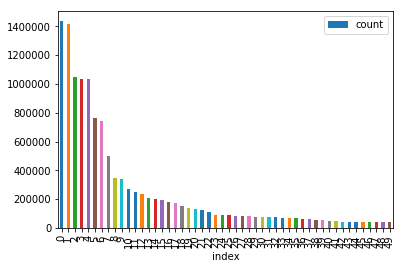

In [70]:
plt.figure(figsize=(20,10))
label_count_dis_df[:50].plot(y='count', kind='bar', use_index=True)

In [77]:
print(f"totoal number of label appearance {label_count_dis_df['count'].sum()}")
label_count_dis_df['count'].describe()

totoal number of label appearance 14610229


count    5.990000e+02
mean     2.439103e+04
std      1.241186e+05
min      4.000000e+00
25%      3.985000e+02
50%      1.287000e+03
75%      4.897500e+03
max      1.438128e+06
Name: count, dtype: float64

In [88]:
count_sum = 0
measure_level = [0.5, 0.75, 0.9, 0.95, 0.99]
curr_level = 0
for cut_off in range(500):
    count_sum += label_count_dis_df['count'][cut_off]
    if (count_sum >= label_count_dis_df['count'].sum() * measure_level[curr_level]):
        print(f"The top {cut_off} most frequent label take up {measure_level[curr_level]*100} % of the total label appearance\n")
        curr_level += 1
    if curr_level >= len(measure_level):
        break;

The top 6 most frequent label take up 50.0 % of the total label appearance

The top 22 most frequent label take up 75.0 % of the total label appearance

The top 63 most frequent label take up 90.0 % of the total label appearance

The top 115 most frequent label take up 95.0 % of the total label appearance

The top 295 most frequent label take up 99.0 % of the total label appearance



###### It might be a wiser idea to work on identifying the most frequent 50 labels first and then extend the range if needed and possible

### Now let's look at how frequently labels appear by image count

In [17]:
label_appear_image_df = train_box_df.groupby('LabelName')['ImageID'].nunique().reset_index()

In [18]:
label_appear_image_df = label_appear_image_df.sort_values('ImageID',ascending=False)

In [19]:
label_appear_image_df.rename({'ImageID':'ImageCount'}, axis=1,inplace=True)
label_appear_image_df.rename({'LabelName':'LabelID'}, axis=1,inplace=True)
label_appear_image_df['LabelName'] = label_appear_image_df['LabelID'].map(label_name_dict)

In [21]:
label_appear_image_df.head(100)

,LabelID,ImageCount,LabelName
305,/m/04yx4,378077,Man
500,/m/0dzct,331627,Human face
430,/m/09j2d,327818,Clothing
388,/m/07j7r,289999,Tree
227,/m/03bt1vf,265635,Woman
67,/m/01g317,248384,Person
431,/m/09j5n,130723,Footwear
463,/m/0cgh4,104007,Building
330,/m/05r655,93731,Girl
568,/m/0k4j,89465,Car


<Figure size 1440x720 with 0 Axes>

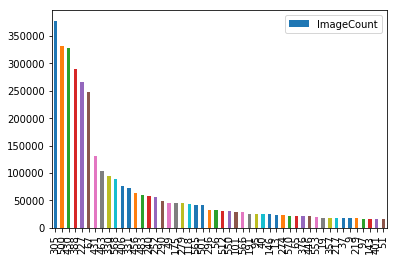

In [119]:
plt.figure(figsize=(20,10))
label_appear_image_df[:50].plot(y='ImageCount', kind='bar', use_index=True)

In [120]:
print(f"totoal number of label appearance {label_appear_image_df['ImageCount'].sum()}")
label_appear_image_df['ImageCount'].describe()

totoal number of label appearance 4423503


count       599.000000
mean       7384.813022
std       32895.133612
min           3.000000
25%         264.000000
50%         745.000000
75%        2232.500000
max      378077.000000
Name: ImageCount, dtype: float64

In [123]:
count_sum = 0
measure_level = [0.5, 0.75, 0.9, 0.95, 0.99]
curr_level = 0
for cut_off in range(599):
    count_sum += label_appear_image_df['ImageCount'][cut_off]
    if (count_sum >= label_appear_image_df['ImageCount'].sum() * measure_level[curr_level]):
        print(f"The top {cut_off} most frequent label take up {measure_level[curr_level]*100} % of the total per image appearance\n")
        curr_level += 1
    if curr_level >= len(measure_level):
        break;

The top 330 most frequent label take up 50.0 % of the total per image appearance

The top 433 most frequent label take up 75.0 % of the total per image appearance

The top 500 most frequent label take up 90.0 % of the total per image appearance

The top 555 most frequent label take up 95.0 % of the total per image appearance

The top 568 most frequent label take up 99.0 % of the total per image appearance



#### OK... By image count, the dataset is not that biased. But for those very infrequent objects, it would still be extreamly hard to get the model trained on them well enough